In [3]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, plot_roc_curve, matthews_corrcoef
import seaborn as sns
from dtreeviz.trees import *

In [4]:
df = pd.read_csv("solubility_data_ok.csv")
df

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT,bin,is_sol
0,A-14,bis(4-fluorophenyl)methanone,InChI=1S/C13H8F2O/c14-11-5-1-9(2-6-11)13(16)10...,LSQARZALBDFYQZ-UHFFFAOYSA-N,Fc1ccc(cc1)C(=O)c2ccc(F)cc2,-4.396652,0.431513,2,G3,218.202,...,2.0,0.0,0.0,2.0,17.07,91.346032,2.315628e+00,452.960733,Medium,False
1,A-15,1-[2-(benzoyloxy)propoxy]propan-2-yl benzoate ...,InChI=1S/C20H22O5/c21-19(17-9-3-1-4-10-17)24-1...,BYQDGAVOOHIJQS-UHFFFAOYSA-N,O=C(OCCCOCCCOC(=O)c1ccccc1)c2ccccc2,-4.595503,0.118551,2,G3,342.391,...,2.0,0.0,0.0,2.0,61.83,147.071714,1.447050e+00,582.150793,Low,False
2,A-19,"2,3-dimethylphenol; 2,4-dimethylphenol; 2,5-di...",InChI=1S/6C8H10O/c1-6-3-7(2)5-8(9)4-6;1-6-3-4-...,YJZHZFOWHRKQHS-UHFFFAOYSA-N,Cc1ccc(O)c(C)c1.Cc2ccc(C)c(O)c2.Cc3cc(C)cc(O)c...,-1.980310,0.155859,4,G5,733.002,...,6.0,0.0,0.0,6.0,121.38,322.890738,3.240000e-07,1804.418547,High,True
3,A-23,"(2E)-3,7-dimethylocta-2,6-dien-1-ol","InChI=1S/C10H18O/c1-9(2)5-4-6-10(3)7-8-11/h5,7...",GLZPCOQZEFWAFX-YFHOEESVSA-N,CC(C)=CCC\C(C)=C/CO,-2.320601,0.071633,4,G5,154.253,...,0.0,0.0,0.0,0.0,20.23,69.438758,3.544387e+00,150.255712,High,True
4,A-24,2-(4-chloro-2-methylphenoxy)propanoic acid,InChI=1S/C10H11ClO3/c1-6-5-8(11)3-4-9(6)14-7(2...,WNTGYJSOUMFZEP-UHFFFAOYSA-N,CC(Oc1ccc(Cl)cc1C)C(O)=O,-2.466031,0.060621,4,G5,214.648,...,1.0,0.0,0.0,1.0,46.53,87.263739,2.817665e+00,349.220389,High,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1813,I-76,sarafloxacin,InChI=1S/C20H17F2N3O3/c21-12-1-3-13(4-2-12)25-...,XBHBWNFJWIASRO-UHFFFAOYSA-N,C1CN(CCN1)c1c(cc2c(n(cc(C(=O)O)c2=O)c2ccc(cc2)...,-3.130000,0.005000,2,G3,385.370,...,3.0,1.0,1.0,4.0,74.57,158.176705,2.013165e+00,1120.229459,High,True
1814,I-79,sulfamethazine,InChI=1S/C12H14N4O2S/c1-8-7-9(2)15-12(14-8)16-...,ASWVTGNCAZCNNR-UHFFFAOYSA-N,S(=O)(=O)(Nc1nc(C)cc(n1)C)c1ccc(N)cc1,-2.730000,0.230750,2,G3,278.337,...,2.0,0.0,0.0,2.0,97.97,111.308206,2.330509e+00,675.919365,High,True
1815,I-83,sulindac_form_II,InChI=1S/C20H17FO3S/c1-12-17(9-13-3-6-15(7-4-1...,MLKXDPUZXIRXEP-RQZCQDPDSA-N,CC1=C(CC(O)=O)c2cc(F)ccc2C\1=C\c1ccc(cc1)S(C)=O,-4.500000,0.410000,2,G3,356.418,...,2.0,0.0,1.0,3.0,54.37,147.518542,2.101112e+00,939.913669,Medium,False
1816,I-86,thymol,InChI=1S/C10H14O/c1-7(2)9-5-4-8(3)6-10(9)11/h4...,MGSRCZKZVOBKFT-UHFFFAOYSA-N,c1(cc(ccc1C(C)C)C)O,-2.190000,0.019222,3,G5,150.221,...,1.0,0.0,0.0,1.0,20.23,67.685405,3.092720e+00,251.049732,High,True


In [5]:
desc_columns = df.select_dtypes([int,float]).columns[3:]
desc_columns

Index(['MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount', 'NumHAcceptors',
       'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
       'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings',
       'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ',
       'BertzCT'],
      dtype='object')

In [14]:
desc_columns = desc_columns[:-2]

In [15]:
train, test = train_test_split(df)

In [16]:
len(df),len(train),len(test)

(1818, 1363, 455)

In [17]:
train_X = train[desc_columns]
train_y = train.is_sol
test_X = test[desc_columns]
test_y = test.is_sol

In [18]:
cls = DecisionTreeClassifier(max_depth=2)

In [19]:
cls.fit(train_X,train_y)

DecisionTreeClassifier(max_depth=2)

In [20]:
pred = cls.predict(test_X)

In [21]:
roc_auc_score(test_y,pred)

0.8394403215831788

In [22]:
matthews_corrcoef(test_y,pred)

0.7224109697871536

In [23]:
probs = cls.predict_proba(test_X)

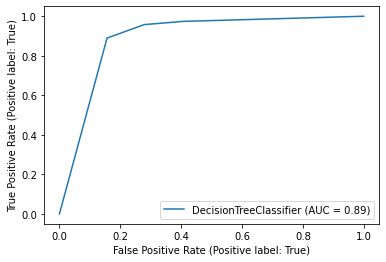

In [24]:
plot_roc_curve(cls,test_X,test_y)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


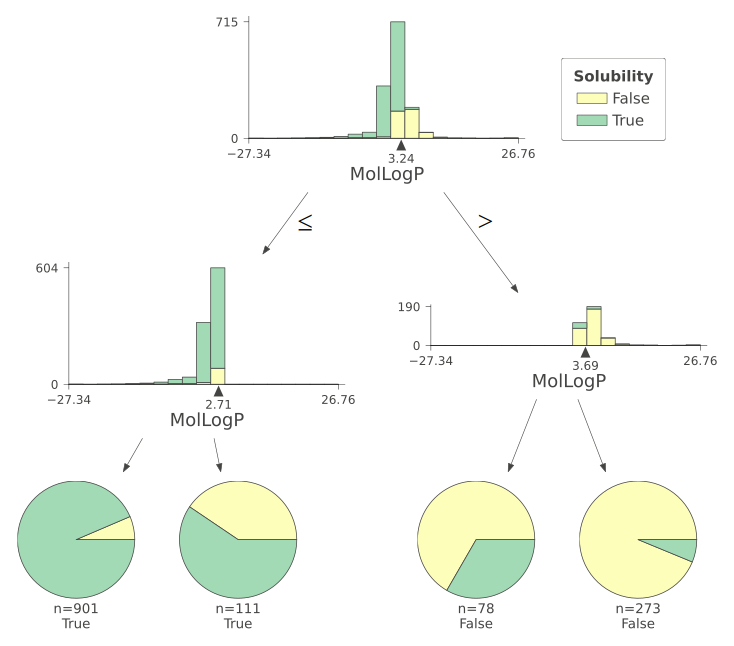

In [25]:
feature_names = list(desc_columns)
viz = dtreeviz(cls, train_X, train_y, feature_names = feature_names, 
               target_name = "Solubility",class_names=["False","True"],scale=2)
viz